In [22]:
import os
import numpy as np
from skimage import io,color
from skimage import filters
from skimage import exposure
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing,svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold , cross_val_score,KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")

In [23]:
Dog_images = r'Sreenu_images'

In [24]:
#Image edge histogram conversion 

In [25]:
#as specified in assignment 1
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

dog_hist = []
dog_breeds     = []
for index,breed_name in enumerate(os.listdir(Dog_images)):
    path=os.path.join(Dog_images,breed_name)
    for image_file in os.listdir(path):
        image    = io.imread(os.path.join(path,image_file.strip()))
        image=color.rgb2gray(image)
        image = angle(filters.sobel_h(image),filters.sobel_v(image))
        hist,_=exposure.histogram(image, nbins=36)
        dog_hist.append(hist)
        dog_breeds.append(index)
dog_hist=np.array(dog_hist)
dog_breeds=np.array(dog_breeds)


In [26]:
#step 3, 4, 5 we split data based on dog breeds and use standard scalar to normalize/scale data

X_train, X_test, y_train, y_test = train_test_split(dog_hist, dog_breeds, test_size=0.2, stratify=dog_breeds,random_state=42)
scaler = preprocessing.StandardScaler()
X_trainscaled = scaler.fit_transform(X_train)
X_testscaled = scaler.transform(X_test)

In [27]:
# (Model Selection)  𝑘 = 1,3,5,7,10,20

neighbors = [1,3,5,7,10,20]

def model_selection(model):
    train_errors =[]
    val_errors=[]
    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n)
        train = []
        val=[]
        for trainindex, testindex in model.split(X_trainscaled, y_train):
            xtrain, xval = X_trainscaled[trainindex], X_trainscaled[testindex]
            ytrain, yval = y_train[trainindex], y_train[testindex]
            knn.fit(xtrain, ytrain)
            train_pred = knn.predict(xtrain)
            val_pred = knn.predict(xval)
            train_acc = accuracy_score(ytrain, train_pred)
            val_acc = accuracy_score(yval, val_pred)
            train.append(1-train_acc)
            val.append(1-val_acc)
        train_errors.append(np.mean(train))
        val_errors.append(np.mean(val))
    return train_errors,val_errors
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

standard_train,standard_val=model_selection(kf)
stratified_train,stratified_val=model_selection(skf)

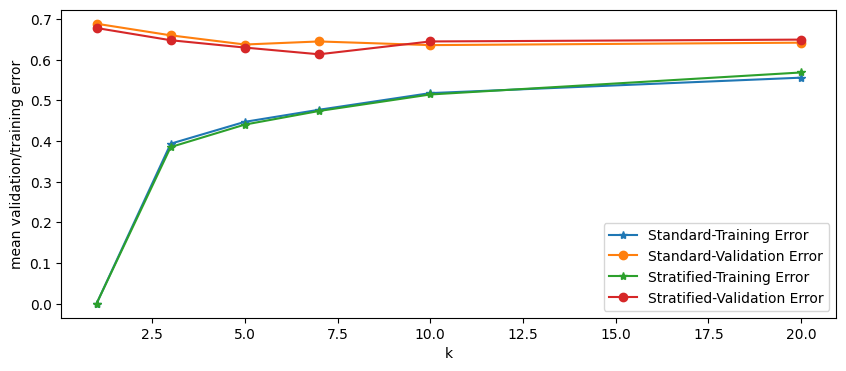

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(neighbors, standard_train, label='Standard-Training Error',marker='*')
plt.plot(neighbors, standard_val, label='Standard-Validation Error',marker='o')
plt.plot(neighbors, stratified_train, label='Stratified-Training Error',marker='*')
plt.plot(neighbors, stratified_val, label='Stratified-Validation Error',marker='o')
plt.xlabel('k')
plt.ylabel('mean validation/training error')
plt.legend()
plt.show()

In [30]:
#test error 
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_trainscaled, y_train)
pred = knn.predict(X_testscaled)
print("Test Error at k= 7 :" +str(1-(accuracy_score(y_test,pred))))

Test Error at k= 7 :0.6467065868263473


###### Model complexity with respect to K value:
High K value (Lower Model Complexity): When the K value is high, the model considers a larger number of nearest neighbors to make predictions. This leads to a smoother decision boundary and lower model complexity. 
alue (Higher Model Complexity): Conversely, when the K value is low, the model considers fewer nearest neighbors, resulting in a more complex decision boundary. 

###### Overfitting and Underfitting
Higher K values lead to lower model complexity, reducing the risk of overfitting but potentially increasing the risk of underfitting.
Lower K values lead to higher model complexity, allowing the model to capture finer details in the data but increasing the risk of overfitting.

In [31]:
#(PerformanceComparison) # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

## 1 -model SVM  Support Vector Machine (SVM): LinearSVC with default parameters.

mean validation accuracy : 0.35037593984962406
 test accuracy : 0.33532934131736525
 f1 Measure : 0.33633346334151626


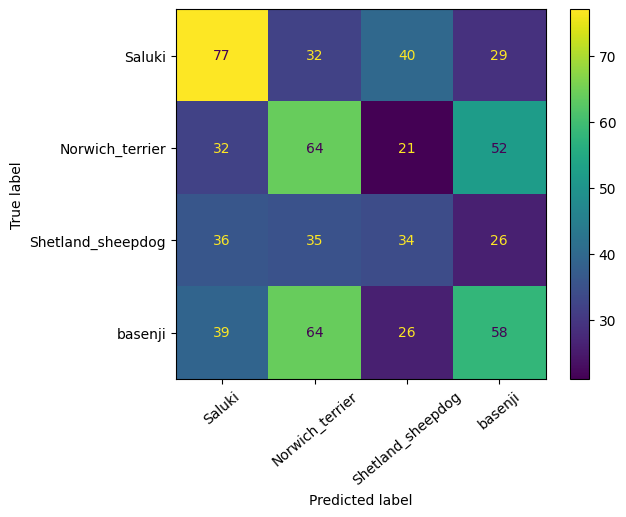

In [32]:
true_labels=[]
predicted_labels=[]
confusion_m=[]
validation_acc=[]
#https://scikit-learn.org/stable/modules/svm.html#classification
SVM=svm.LinearSVC()

for trainindex, testindex in skf.split(X_trainscaled, y_train):
    xtrain, xval = X_trainscaled[trainindex], X_trainscaled[testindex]
    ytrain, yval = y_train[trainindex], y_train[testindex]
    SVM.fit(xtrain, ytrain)
    pred=SVM.predict(xval)
    true_labels.extend(yval)
    predicted_labels.extend(pred)
    val_acc = accuracy_score(yval,pred)
    validation_acc.append(val_acc)
print("mean validation accuracy : "+str(np.mean(validation_acc)))
test_accuracy = accuracy_score(y_test, SVM.predict(X_testscaled))
print(" test accuracy : "+str(test_accuracy))
f1 = f1_score(y_test, SVM.predict(X_testscaled), average='weighted')
print(" f1 Measure : "+str(f1))

confusion_m.append(confusion_matrix(true_labels, predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(confusion_m)/len(confusion_m), display_labels =['Saluki', 'Norwich_terrier', 'Shetland_sheepdog', 'basenji'] )
cm_display.plot(xticks_rotation=40)
plt.show()


## Neural Network: MLPClassifier with parameter ℎ𝑖𝑑𝑑𝑒𝑛 𝑙𝑎𝑦𝑒𝑟 𝑠𝑖𝑧𝑒𝑠 = (10,10,10,) (i.e., 3  hidden layers with 10 nodes each) and default values for the other parameters.

mean validation accuracy : 0.36240601503759395
 test accuracy : 0.3712574850299401
 f1 Measure : 0.36554055901817967


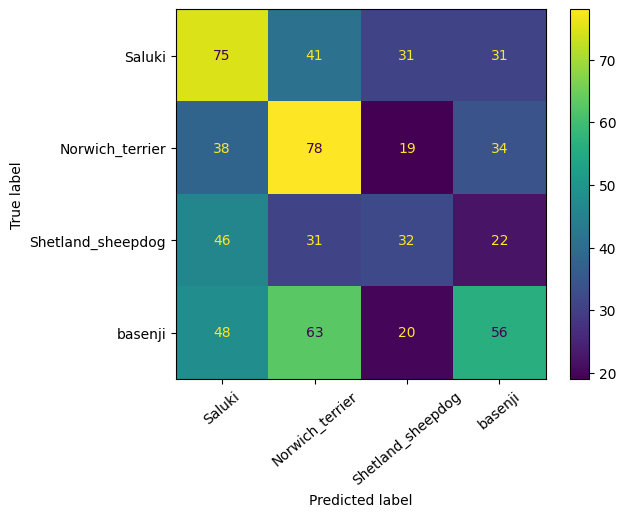

In [33]:
true_labels=[]
predicted_labels=[]
confusion_m=[]
validation_acc=[]
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
MLP=MLPClassifier(hidden_layer_sizes=(10,10,10))

for trainindex, testindex in skf.split(X_trainscaled, y_train):
    xtrain, xval = X_trainscaled[trainindex], X_trainscaled[testindex]
    ytrain, yval = y_train[trainindex], y_train[testindex]
    MLP.fit(xtrain, ytrain)
    pred=MLP.predict(xval)
    true_labels.extend(yval)
    predicted_labels.extend(pred)
    val_acc = accuracy_score(yval,pred)
    validation_acc.append(val_acc)
print("mean validation accuracy : "+str(np.mean(validation_acc)))
test_accuracy = accuracy_score(y_test, MLP.predict(X_testscaled))
print(" test accuracy : "+str(test_accuracy))
f1 = f1_score(y_test, MLP.predict(X_testscaled), average='weighted')
print(" f1 Measure : "+str(f1))

confusion_m.append(confusion_matrix(true_labels, predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(confusion_m)/len(confusion_m), display_labels =['Saluki', 'Norwich_terrier', 'Shetland_sheepdog', 'basenji'] )
cm_display.plot(xticks_rotation=40)
plt.show()

## Random Forest: RandomForestClassifier with default parameters.

mean validation accuracy : 0.3699248120300752
 test accuracy : 0.3592814371257485
 f1 Measure : 0.357278473098352


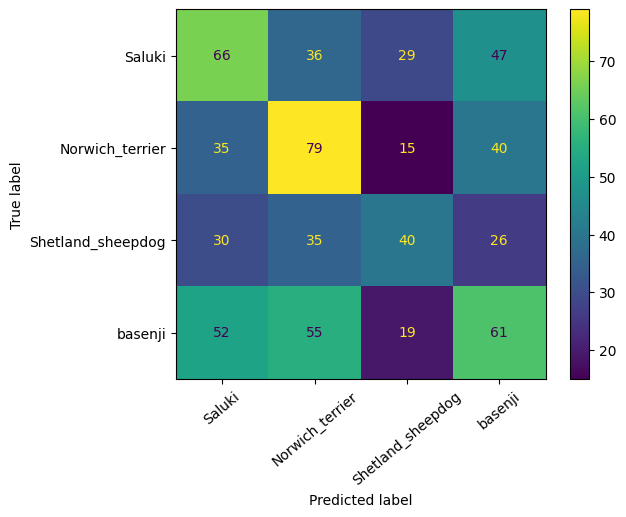

In [34]:
true_labels=[]
predicted_labels=[]
confusion_m=[]
validation_acc=[]
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
RF=RandomForestClassifier()
for trainindex, testindex in skf.split(X_trainscaled, y_train):
    xtrain, xval = X_trainscaled[trainindex], X_trainscaled[testindex]
    ytrain, yval = y_train[trainindex], y_train[testindex]
    RF.fit(xtrain, ytrain)
    pred=RF.predict(xval)
    true_labels.extend(yval)
    predicted_labels.extend(pred)
    val_acc = accuracy_score(yval,pred)
    validation_acc.append(val_acc)
print("mean validation accuracy : "+str(np.mean(validation_acc)))
test_accuracy = accuracy_score(y_test, RF.predict(X_testscaled))
print(" test accuracy : "+str(test_accuracy))
f1 = f1_score(y_test, RF.predict(X_testscaled), average='weighted')
print(" f1 Measure : "+str(f1))

confusion_m.append(confusion_matrix(true_labels, predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(confusion_m)/len(confusion_m), display_labels =['Saluki', 'Norwich_terrier', 'Shetland_sheepdog', 'basenji'] )
cm_display.plot(xticks_rotation=40)
plt.show()

### confusion matrix best :random forest as this model classifies precisely with good number of breeds
### mean validation accuracy best : random forest (highest)
### Test accuracy best : MLP classifier
### F1 measure : MLP classifier 